##CNN

- k-fold cross-validation applied
- IMG_SIZE = 32
- BATCH_SIZE = 32
- EPOCHS = 30
- Lr = 0.001

##Findings:
Accuracy: 98.12%

#Mount Google Drive and import libraries

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


#Dataset:

##Load training data

In [ ]:
# Define paths to dataset directories
train_dir = '/content/drive/My Drive/Data/GTSRB/Train/GTSRB/Final_Training/Images/'
test_dir = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/'

# Define image size
IMG_SIZE = 32  # Resize images
BATCH_SIZE = 32
num_classes = 43

# Helper function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    # Loop through each subdirectory (which corresponds to a class)
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)

        if os.path.isdir(label_path):
            label = int(label_dir)  # Subdirectory name is the class label

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Check if the file has a valid image extension
                _, file_extension = os.path.splitext(img_file)
                if file_extension.lower() not in valid_extensions:
                    print(f"Skipping non-image file: {img_file}")
                    continue  # Skip non-image files (e.g., CSV)

                # Read the image using OpenCV
                image = cv2.imread(img_path)

                # Resize image
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the image and label to the lists
                images.append(image)
                labels.append(label)

    # Convert to NumPy arrays and normalize
    images = np.array(images, dtype='float32') / 255.0  # Normalize images
    labels = to_categorical(labels, num_classes)  # One-hot encode labels

    return images, labels

# Load training data
images, labels = load_data(train_dir)

Skipping non-image file: GT-00000.csv
Skipping non-image file: GT-00001.csv
Skipping non-image file: GT-00002.csv
Skipping non-image file: GT-00003.csv
Skipping non-image file: GT-00004.csv
Skipping non-image file: GT-00005.csv
Skipping non-image file: GT-00006.csv
Skipping non-image file: GT-00007.csv
Skipping non-image file: GT-00008.csv
Skipping non-image file: GT-00009.csv
Skipping non-image file: GT-00010.csv
Skipping non-image file: GT-00011.csv
Skipping non-image file: GT-00012.csv
Skipping non-image file: GT-00013.csv
Skipping non-image file: GT-00014.csv
Skipping non-image file: GT-00015.csv
Skipping non-image file: GT-00016.csv
Skipping non-image file: GT-00017.csv
Skipping non-image file: GT-00018.csv
Skipping non-image file: GT-00019.csv
Skipping non-image file: GT-00020.csv
Skipping non-image file: GT-00021.csv
Skipping non-image file: GT-00022.csv
Skipping non-image file: GT-00023.csv
Skipping non-image file: GT-00024.csv
Skipping non-image file: GT-00025.csv
Skipping non

##Data Transformation

In [ ]:
### Image Augmentation ###
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=15,        # Rotate images by up to 15 degrees
    zoom_range=0.2,           # Random zoom in/out by up to 20%
    width_shift_range=0.1,    # Shift the image horizontally by 10%
    height_shift_range=0.1,   # Shift the image vertically by 10%
)

# Fit the generator on the training data
datagen.fit(images)

# Create the augmented data generator for training
train_generator = datagen.flow(images, labels, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
print("Number of samples in augmented dataset:", len(train_generator) * BATCH_SIZE)

Number of samples in augmented dataset: 39232


##Apply k-fold cross validation

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the number of folds
K = 3

# Convert categorical labels back to integers for StratifiedKFold
y_labels = np.argmax(labels, axis=1)

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

# Function to create a CNN model
def create_model(input_shape, num_classes):
    # Build a simple CNN model
    model = models.Sequential()

    # Convolutional layer
    model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE, 3))),
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')),
    model.add(layers.MaxPool2D(pool_size=(2, 2))),
    model.add(layers.BatchNormalization(axis=-1)),

    # Add more layers
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')),
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu')),
    model.add(layers.MaxPool2D(pool_size=(2, 2))),
    model.add(layers.BatchNormalization(axis=-1)),

    model.add(layers.Flatten()),
    model.add(layers.Dense(512, activation='relu')),
    model.add(layers.BatchNormalization()),
    model.add(layers.Dropout(rate=0.5)),

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
import os

# Directory to save models
model_save_dir = '/content/drive/My Drive/UH/Data Science Project/GTSRB/Models/'

# Ensure the directory exists
os.makedirs(model_save_dir, exist_ok=True)

# Perform K-Fold Cross-Validation
fold_no = 1
accuracies = []
model_paths = []
EPOCHS = 15

# Initialize lists to store training and validation metrics
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Initialize lists to store metrics
classification_reports = []

# Initialize the cumulative confusion matrix
cumulative_confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.float32)

for train_idx, val_idx in skf.split(images, y_labels):
    print(f"\nTraining fold {fold_no}...")

    # Split the data into training and validation sets
    X_train, X_val = images[train_idx], images[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    # Create a new model instance
    model = create_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes)

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=1
    )

    # Store accuracy and loss for each epoch
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Generate predictions for the validation set
    y_pred = np.argmax(model.predict(X_val), axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Compute classification report for the current fold
    report = classification_report(y_true, y_pred, output_dict=True)
    classification_reports.append(report)

    # Compute confusion matrix for the current fold
    fold_confusion_matrix = confusion_matrix(y_true, y_pred, labels=range(num_classes))

    # Accumulate the confusion matrix
    cumulative_confusion_matrix += fold_confusion_matrix

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy:.4f}")
    accuracies.append(val_accuracy)

    # Save the model
    model_path = os.path.join(model_save_dir, f'model_fold_{fold_no}.h5')
    model.save(model_path)
    model_paths.append(model_path)

    fold_no += 1


Training fold 1...
Epoch 1/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.7473 - loss: 1.0823 - val_accuracy: 0.9814 - val_loss: 0.0656
Epoch 2/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9888 - loss: 0.0388 - val_accuracy: 0.9830 - val_loss: 0.0603
Epoch 3/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9904 - loss: 0.0319 - val_accuracy: 0.9814 - val_loss: 0.0641
Epoch 4/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9916 - loss: 0.0263 - val_accuracy: 0.9922 - val_loss: 0.0249
Epoch 5/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9958 - loss: 0.0157 - val_accuracy: 0.9872 - val_loss: 0.0444
Epoch 6/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9921 - loss: 0.0238 - val_accuracy: 0.9904 - val_loss: 0.0383
Epoch 7/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9938 - loss: 0.0216 - val_accuracy: 0.9847 - val_loss: 0.0483
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


Fold 1 - Validation Accuracy: 0.9922

Training fold 2...
Epoch 1/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7313 - loss: 1.1065 - val_accuracy: 0.9815 - val_loss: 0.0663
Epoch 2/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9887 - loss: 0.0393 - val_accuracy: 0.9915 - val_loss: 0.0280
Epoch 3/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9911 - loss: 0.0300 - val_accuracy: 0.9914 - val_loss: 0.0332
Epoch 4/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9925 - loss: 0.0237 - val_accuracy: 0.9922 - val_loss: 0.0360
Epoch 5/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9927 - loss: 0.0227 - val_accuracy: 0.9921 - val_loss: 0.0286
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Fold 2 - Validation Accuracy: 0.9915

Training fold 3...
Epoch 1/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.7122 - loss: 1.1978 - val_accuracy: 0.9871 - val_loss: 0.0495
Epoch 2/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9888 - loss: 0.0404 - val_accuracy: 0.9897 - val_loss: 0.0384
Epoch 3/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9897 - loss: 0.0326 - val_accuracy: 0.9879 - val_loss: 0.0460
Epoch 4/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9915 - loss: 0.0301 - val_accuracy: 0.9912 - val_loss: 0.0316
Epoch 5/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9929 - loss: 0.0231 - val_accuracy: 0.9931 - val_loss: 0.0300
Epoch 6/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9931 - loss: 0.0221 - val_accuracy: 0.9914 - val_loss: 0.0321
Epoch 7/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9942 - loss: 0.0204 - val_accuracy: 0.9837 - val_loss: 0.0620
Epoch 8/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5m

Fold 3 - Validation Accuracy: 0.9931


In [ ]:
# Summary of results
print("\nCross-Validation Results:")
print(f"Average Validation Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Cross-Validation Results:
Average Validation Accuracy: 0.9923
Standard Deviation: 0.0007


#Evaluate the model

##Accuracy and loss curve

In [ ]:
# Compute averages for each epoch
avg_train_accuracy = [sum(values) / len(values) for values in zip(*train_accuracies)]
avg_val_accuracy = [sum(values) / len(values) for values in zip(*val_accuracies)]
avg_train_loss = [sum(values) / len(values) for values in zip(*train_losses)]
avg_val_loss = [sum(values) / len(values) for values in zip(*val_losses)]

ValueError: x and y must have same first dimension, but have shapes (15,) and (5,)

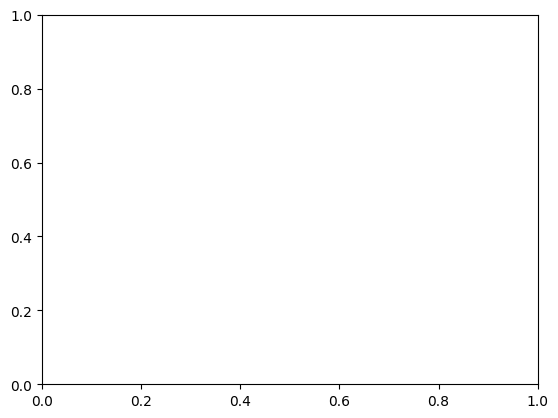

In [ ]:
# Creating epoch numbers starting from 1
epochs_range = range(1, EPOCHS + 1)

# Plot accuracy
plt.plot(epochs_range, avg_train_accuracy, label='train_accuracy')
plt.plot(epochs_range, avg_val_accuracy, label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_range)  # Set x-axis ticks to match epoch numbers
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(epochs_range, avg_train_loss, label='train_loss')
plt.plot(epochs_range, avg_val_loss, label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs_range)  # Set x-axis ticks to match epoch numbers
plt.legend(loc='upper left')
plt.show()


##Classification report

In [ ]:
import pandas as pd

# Compute average classification report
avg_report = {}

# List all class labels (assuming the same structure for all reports)
all_classes = classification_reports[0].keys()

# Iterate through each metric and compute the average
for class_label in all_classes:
    if isinstance(classification_reports[0][class_label], dict):  # Metrics for a specific class
        avg_report[class_label] = {}
        for metric in classification_reports[0][class_label]:
            # Compute the average of the metric across all folds
            avg_report[class_label][metric] = np.mean([
                report[class_label][metric] for report in classification_reports
            ])
    else:  # Aggregate overall metrics (e.g., accuracy)
        avg_report[class_label] = np.mean([
            report[class_label] for report in classification_reports
        ])

#print("Average Classification Report:", average_report)
avg_report

{'0': {'precision': 0.9723454884558492,
  'recall': 0.9952380952380953,
  'f1-score': 0.9836168559572815,
  'support': 70.0},
 '1': {'precision': 0.9822129053154353,
  'recall': 0.9918918918918918,
  'f1-score': 0.9870166947631737,
  'support': 740.0},
 '2': {'precision': 0.9872352825206114,
  'recall': 0.9933333333333333,
  'f1-score': 0.9902527115052239,
  'support': 750.0},
 '3': {'precision': 0.9893990403839769,
  'recall': 0.9907801418439717,
  'f1-score': 0.9900798941285008,
  'support': 470.0},
 '4': {'precision': 0.9974520091391533,
  'recall': 0.9843434343434344,
  'f1-score': 0.9908096382070247,
  'support': 660.0},
 '5': {'precision': 0.9869056580353835,
  'recall': 0.9725806451612904,
  'f1-score': 0.9796750965759343,
  'support': 620.0},
 '6': {'precision': 0.9952378522713744,
  'recall': 0.9952380952380953,
  'f1-score': 0.9952295309889156,
  'support': 140.0},
 '7': {'precision': 0.997207669717222,
  'recall': 0.9868055555555556,
  'f1-score': 0.9919587347017017,
  'supp

##Confusion Matrix

In [ ]:
# Compute the average confusion matrix
average_confusion_matrix = cumulative_confusion_matrix / skf.get_n_splits()

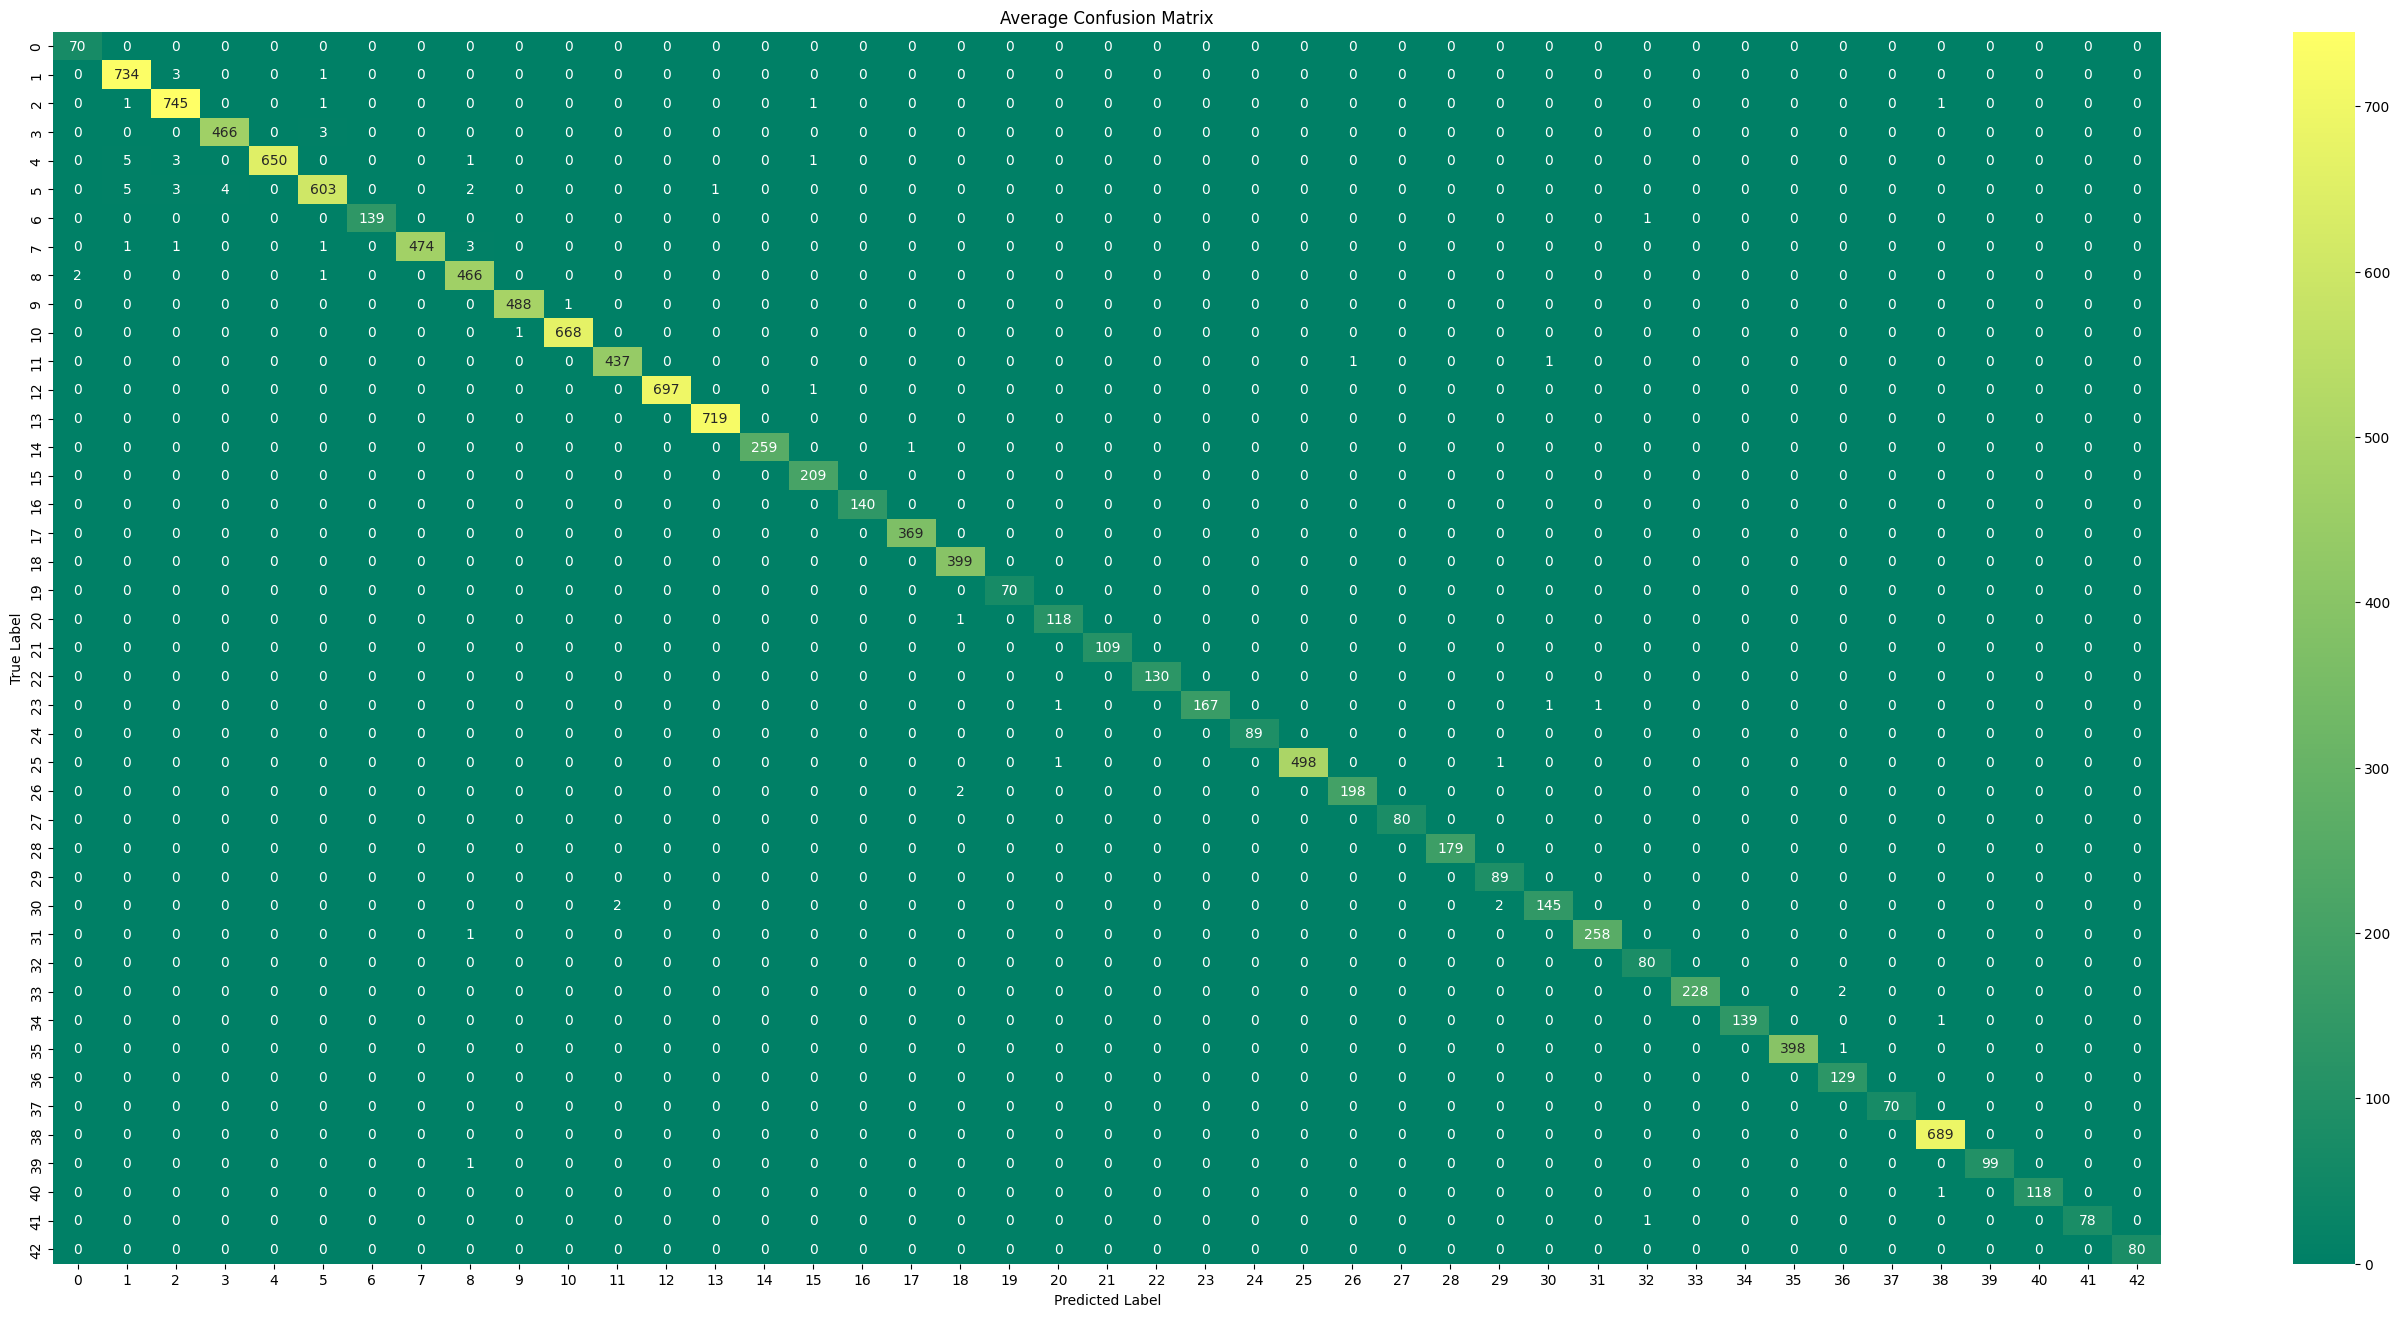

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the average confusion matrix
plt.figure(figsize=(34, 16))
sns.heatmap(
    average_confusion_matrix,
    annot=True,
    fmt=".0f",
    cmap="summer",
    xticklabels=range(num_classes),
    yticklabels=range(num_classes)
)
plt.title("Average Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#Evaluate on test data (unseen data)

##Load test data

In [ ]:
# Load the test dataset
def load_test_data(test_dir):
    images = []
    img_names = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)

        # Check if the file is an image
        _, file_extension = os.path.splitext(img_file)
        if file_extension.lower() not in valid_extensions:
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip non-image files

        # Read and resize the image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Append the image and image file name to the lists
        images.append(image)
        img_names.append(img_file)

    # Convert images to a NumPy array
    images = np.array(images, dtype='float32') / 255.0  # Normalize images

    return images, img_names

# Load test images
X_test, test_img_names = load_test_data(test_dir)

Skipping non-image file: GT-final_test.test.csv


In [ ]:
# Path to test CSV file
test_csv_path = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/GT-final_test.test.csv'
# Load the test labels from the CSV file
test_data = pd.read_csv(test_csv_path, sep=";")

##Make predictions

In [ ]:
# Make predictions using the average of saved models
predictions = np.zeros((X_test.shape[0], num_classes))

for model_path in model_paths:
    print(f"Loading model from {model_path}")
    model = keras.models.load_model(model_path)
    predictions += model.predict(X_test)

# Average predictions
predictions /= len(model_paths)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

Loading model from /content/drive/My Drive/UH/Data Science Project/GTSRB/Models/model_fold_1.h5


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Loading model from /content/drive/My Drive/UH/Data Science Project/GTSRB/Models/model_fold_2.h5


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Loading model from /content/drive/My Drive/UH/Data Science Project/GTSRB/Models/model_fold_3.h5


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


##Save predictions

In [ ]:
# Create a DataFrame to save the image file names and predicted classes
result_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
result_df = result_df.sort_values(by='Filename')

# Save the results to a CSV file
result_df.to_csv('gtsrb_test_predictions.csv', index=False)
print("Predictions saved to 'gtsrb_test_predictions.csv'")

Predictions saved to 'gtsrb_test_predictions.csv'


##Print test accuracy

In [ ]:
import pandas as pd

# Load your predictions
predictions_df = pd.read_csv('gtsrb_test_predictions.csv')

# Load the ground truth file (downloaded separately)
ground_truth_df = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth_df[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 98.12%


##Classification Report

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(merged_df['Predicted Class'], merged_df['ClassId']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.98      0.99       734
           2       0.99      0.98      0.99       757
           3       0.97      0.99      0.98       440
           4       0.98      0.99      0.99       654
           5       0.98      0.96      0.97       640
           6       0.83      1.00      0.91       124
           7       0.97      0.99      0.98       441
           8       1.00      0.98      0.99       456
           9       1.00      0.99      0.99       486
          10       0.99      1.00      0.99       655
          11       1.00      0.97      0.98       432
          12       0.97      1.00      0.98       670
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      0.91      0.95       231
          16       0.99      1.00      1.00       149
          17       1.00    